# Data Exploration

The dataset has:

- 2126 different texts
- 5 classes: entertainment, sport, tech, business, or politics.

In [28]:
datapath = './bbc-text.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


<Axes: xlabel='category'>

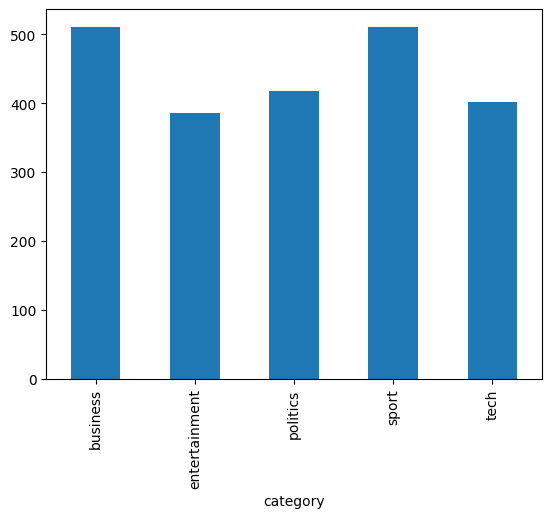

In [29]:
df.groupby(['category']).size().plot.bar()

# Data Preprocessing 

Transform the text into the format that BERT expects by adding [CLS] and [SEP] tokens. Do this easily with BertTokenizer class from Hugging Face.

BertTokenizer parameters:

- padding : to pad each sequence to the maximum length that you specify.
- max_length : the maximum length of each sequence. In this example we use 10, but for our actual dataset we will use 512, which is the maximum length of a sequence allowed for BERT.
- truncation : if True, then the tokens in each sequence that exceed the maximum length will be truncated.
- return_tensors : the type of tensors that will be returned. Since we’re using Pytorch, then we use pt. If you use Tensorflow, then you need to use tf .


The tokeniser returns a dictionary with the following keys:

- input_ids : the token ids to be fed to a model. This is the id representation of the tokens in the sequence.
- attention_mask : a mask to be used by the attention mechanism of the model to avoid performing attention on padding token indices.
- token_type_ids : segment token indices to indicate first and second portions of the inputs.

In [30]:
# The tokenizer will be used to convert the text into the input tokens 
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [31]:
example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")

print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


Analyse the outputs

Decoding these inputids into the actual tokens as follows

- The first token is always the [CLS] token. This is used to indicate that this is the beginning of the sequence.
- The last token is always the [SEP] token. This is used to indicate that this is the end of the sequence.
- At the end of the sequence, the padding tokens are added.
- The tokens in between are the actual tokens of the sequence.

In [32]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]


The BertTokenizer takes care of all of the necessary transformations of the input text such that it’s ready to be used as an input for the BERT model. It adds [CLS], [SEP], and [PAD] tokens automatically. Since the maximum length is set to be 10, then there are only two [PAD] tokens at the end.

1. The second row is token_type_ids, which is a binary mask that identifies in which sequence a token belongs. If there is only a single sequence, then all of the token type ids will be 0. For a text classification task, token_type_ids is an optional input for our BERT model.

2. The third row is attention_mask, which is a binary mask that identifies whether a token is a real word or just padding. If the token contains [CLS], [SEP], or any real word, then the mask would be 1. Meanwhile, if the token is just padding or [PAD], then the mask would be 0.

Using a pre-trained BertTokenizer from bert-base-cased model works well if the text in the dataset is in English.

If you have datasets from different languages, its better to use bert-base-multilingual-cased. Specifically, if the dataset is in German, Dutch, Chinese, Japanese, or Finnish, use a tokenizer pre-trained specifically in these languages.

# Dataset Class

Now that the kind of output that is returned BertTokenizer is known, build a Dataset class for the news dataset that will serve as a class to generate news data.

Define a variable called labels, which is a dictionary that maps the category in the dataframe into the id representation of our label.

Call BertTokenizer in the __init__ function above to transform the input texts into the format that BERT expects.

After defining dataset class, let’s split the dataframe into training, validation, and test set with the proportion of 80:10:10.

In [33]:
class Dataset(torch.utils.data.Dataset):
    """
    This class is responsible for loading the data and returning the data point and its label at a given index.
    """

    def __init__(self, df):
        tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        mapped_labels = {'business':0,
                'entertainment':1,
                'sport':2,
                'tech':3,
                'politics':4
                }

        
        self.labels = [mapped_labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        """
        Get item method, responsible for returning the data point and its label at the given index.

        """

        # Get item from the dataset with the given index
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

    def __len__(self):
        return len(self.labels)

# Split the Dataset

In [34]:
np.random.seed(112)

# Split the dataset into train, validation and test sets
# Typically this is done with the sklearn.model_selection.train_test_split function
# But this is a manual implementation 
# df.sample(frac=1, random_state=42) shuffles the dataset 
# np.split splits the dataset into 3 parts with the given ratios (0.8, 0.1, 0.1)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])


print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [35]:
train, val = Dataset(df_train), Dataset(df_val)


train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
for train_input, train_label in tqdm(train_dataloader):
    print(train_input)

 19%|█▉        | 172/890 [00:00<00:00, 1716.21it/s]

{'input_ids': tensor([[[  101, 12477,  3740,  ...,     0,     0,     0]],

        [[  101,  6442,   185,  ..., 11195,  4267,   102]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 1, 1, 1]]])}
{'input_ids': tensor([[[  101,  1185, 13286,  ..., 21363,  1166,   102]],

        [[  101,  1402, 26791,  ...,     0,     0,     0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 0, 0, 0]]])}
{'input_ids': tensor([[[  101,  4190,  2817,  ...,   188,  2052,   102]],

        [[  101, 12261,  1104,  ...,     0,     0,     0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 0, 0, 0]]])}
{'input_ids': tensor([[[ 101, 1

 59%|█████▊    | 521/890 [00:00<00:00, 1717.55it/s]

{'input_ids': tensor([[[  101, 11709,  7253,  ...,     0,     0,     0]],

        [[  101,  6588,   182,  ...,     0,     0,     0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]])}
{'input_ids': tensor([[[  101,  1366,  1590,  ...,     0,     0,     0]],

        [[  101,  5365,  1166,  ...,  1197, 20844,   102]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 1, 1, 1]]])}
{'input_ids': tensor([[[  101,  7688,  8178,  ..., 22662,  1197,   102]],

        [[  101,  3840,  1874,  ...,     0,     0,     0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 0, 0, 0]]])}
{'input_ids': tensor([[[  101, 

100%|██████████| 890/890 [00:00<00:00, 1706.08it/s]

{'input_ids': tensor([[[ 101, 3821, 1324,  ...,    0,    0,    0]],

        [[ 101, 2095, 2472,  ..., 1701,  119,  102]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 1, 1, 1]]])}
{'input_ids': tensor([[[  101,  1344,  4109,  ...,     0,     0,     0]],

        [[  101,   171, 20293,  ...,  1163,  1119,   102]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 1, 1, 1]]])}
{'input_ids': tensor([[[ 101,  187, 3556,  ...,    0,    0,    0]],

        [[ 101,  175, 1200,  ..., 1111, 1143,  102]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 1, 1, 1]]])}
{'input_ids': tensor([[[ 101, 1119, 1179,  ...,    0,  

# Model Building

First build a dataset class to generate the data. Now build the actual model using a pre-trained BERT base model which has 12 layers of Transformer encoder 

As you can see from the code above, BERT model outputs two variables:

The first variable, named _ in the code above, contains the embedding vectors of all of the tokens in a sequence.

The second variable, named pooled_output, contains the embedding vector of [CLS] token. For a text classification task, it is enough to use this embedding as an input for our classifier.

Pass the pooled_output variable into a linear layer with ReLU activation function. At the end of the linear layer, there is a vector of size 5, each corresponds to a category of our labels (sport, business, politics, entertainment, and tech).

In [36]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        # Call the constructor of the parent class, which in this case is the nn.Module class this allows us to use pytorch's nn.Module functions
        super(BertClassifier, self).__init__()

        # Load the BERT base model from the transformers library
        self.bert = BertModel.from_pretrained('bert-base-cased')

        # Freeze the BERT model parameters, this means that we will not update the weights of the BERT model during training
        for param in self.bert.parameters():
            param.requires_grad = False 
            
        # ! Create bespoke additional layers for the classifier model
        # Create a dropout layer, this is used to prevent overfitting by randomly setting some of the activations to zero
        self.dropout = nn.Dropout(dropout)

        # Create a linear layer to map the output of the BERT model to the number of classes
        self.linear = nn.Linear(768, 5)

        # Create a ReLU activation function to be used in the final layer of the model such that the output is between 0 and 1
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        """
        Forward pass of the model, this is where the input is passed through the layers of the model to produce the output.

        Args:
            input_id (_type_): _description_
            mask (_type_): _description_

        Returns:
            _type_: _description_
        """
        
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

# Training Loop

The training loop is a standard PyTorch training loop https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

Train the model for 5 epochs and we use Adam as the optimizer, while the learning rate is set to 1e-6. 

Use categorical cross entropy as our loss function since we’re dealing with multi-class classification.

It is recommended that you use GPU to train the model since BERT base model contains 110 million parameters.

In [37]:
def train(model, train_data, val_data, learning_rate, epochs):
    """
    Function to train the model.

    Args:
        model (_type_): _description_
        train_data (_type_): _description_
        val_data (_type_): _description_
        learning_rate (_type_): _description_
        epochs (_type_): _description_
    """

    # Create the dataset objects for the training and validation data
    train, val = Dataset(train_data), Dataset(val_data)

    # Create the dataloader objects for the training and validation data
    # The dataloader is responsible for batching the data and shuffling the data
    # In this instance the batch size is 2, meaning that the model will be trained on 2 samples at a time and the dataloader will therfore return 2 samples at a time
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    # This will return True if a GPU is available
    use_cuda = torch.cuda.is_available()
    
    # Tell PyTorch to use the GPU if it is available else use the CPU
    device = torch.device("cuda" if use_cuda else "cpu")

    # Create the loss function and the optimizer
    # Here we are using CrossEntropyLoss as our loss function as we are performing multi-class classification
    criterion = nn.CrossEntropyLoss()
    # Here we are using the Adam optimizer, this is a popular optimizer that is used for NLP tasks
    optimizer = Adam(model.parameters(), lr= learning_rate)

    # If a GPU is available then move the model and the loss function to the GPU
    if use_cuda:

            # Move the model to the GPU
            model = model.cuda()
            # Move the loss function to the GPU
            criterion = criterion.cuda()

    # Outer loop to handle the number of epochs
    for epoch_num in range(epochs):

            print(f"Starting training loop for epoch {epoch_num + 1}")
        
            total_acc_train = 0
            total_loss_train = 0

            # Inner training loop to train the model on the training data
            # tqdm is a library that is used to create a progress bar for the training loop
            for train_input, train_label in tqdm(train_dataloader):
                
                # Usig pt the training parameters have to be moved to the device
                # Move the training data to the device
                train_label = train_label.to(device)

                # Move the training data to the device
                mask = train_input['attention_mask'].to(device)

                # Move the training data to the device, note that we are using the squeeze function to remove the first dimension of the tensor, the first dimension is the batch size
                input_id = train_input['input_ids'].squeeze(1).to(device)

                # Perform the forward pass of the model
                output = model(input_id, mask)

                # Calculate the loss 
                batch_loss = criterion(output, train_label.long())

                # Calculate the accuracy
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                
                # Perform the backward pass of the model
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            

            print('Starting Validation Loop for Epoch: ', epoch_num + 1)
            total_acc_val = 0
            total_loss_val = 0

            # Disable gradient calculation for the validation loop
            # Validation calculation is performed after every epoch, we do not want to calculate the gradients for the validation loop as we are not training the model
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')



In [38]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6

# Either train or load the model
if not os.path.exists('./model.pt'):
    train(model, df_train, df_val, LR, EPOCHS)
    torch.save(model.state_dict(), 'model.pt')

else:
    model.load_state_dict(torch.load('model.pt'))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting training loop for epoch 1


100%|██████████| 890/890 [00:43<00:00, 20.57it/s]


Starting Validation Loop for Epoch:  1
Epochs: 1 | Train Loss:  0.830                 | Train Accuracy:  0.196                 | Val Loss:  0.844                 | Val Accuracy:  0.176
Starting training loop for epoch 2


100%|██████████| 890/890 [00:44<00:00, 20.09it/s]


Starting Validation Loop for Epoch:  2
Epochs: 2 | Train Loss:  0.819                 | Train Accuracy:  0.215                 | Val Loss:  0.829                 | Val Accuracy:  0.216
Starting training loop for epoch 3


100%|██████████| 890/890 [00:43<00:00, 20.26it/s]


Starting Validation Loop for Epoch:  3
Epochs: 3 | Train Loss:  0.819                 | Train Accuracy:  0.214                 | Val Loss:  0.832                 | Val Accuracy:  0.234
Starting training loop for epoch 4


100%|██████████| 890/890 [00:44<00:00, 19.97it/s]


Starting Validation Loop for Epoch:  4
Epochs: 4 | Train Loss:  0.816                 | Train Accuracy:  0.214                 | Val Loss:  0.827                 | Val Accuracy:  0.167
Starting training loop for epoch 5


100%|██████████| 890/890 [00:44<00:00, 20.18it/s]


Starting Validation Loop for Epoch:  5
Epochs: 5 | Train Loss:  0.818                 | Train Accuracy:  0.197                 | Val Loss:  0.814                 | Val Accuracy:  0.225


# Evaluate Model on Test Data

Use the test data to evaluate the model’s performance on unseen data. Below is the function to evaluate the performance of the model on the test set.

In [39]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.291


End